

> This notebook presents a complete workflow for tri-class sentiment classification on the FiReCS dataset of Taglish product reviews. The pipeline begins with data loading, cleaning, and a reproducible 80/20 stratified split that preserves class balance and writes split IDs to disk for consistent evaluation across runs. A simple baseline is then established using TF-IDF features with Logistic Regression to provide an interpretable reference score. The workflow proceeds to transformer fine-tuning with two backbones: a multilingual encoder (XLM-RoBERTa) and a Filipino-prior encoder (RoBERTa-Tagalog). Both models are adapted to three sentiment labels and trained using a shared evaluation function that reports macro-F1 and accuracy on the fixed validation split.

> Each section of the notebook follows a consistent structure to aid replication. The preprocessing cell prepares tokenization with a fixed sequence length and converts the data into tensor-ready datasets. The training cell configures arguments, constructs the trainer, performs fine-tuning, evaluates on the validation set, and saves the best checkpoint together with its tokenizer. A brief inference cell verifies behavior on short sample texts, while an analysis cell produces a confusion matrix and a per-class report to explain common errors between negative, neutral, and positive. A final export cell aggregates all runs into a single log, writes spreadsheet summaries for grading and reporting, and highlights the strongest configuration per model.

> The notebook supports both thorough runs and quick sweeps. A fast mode reduces training time by using a smaller training slice and an optional early-stopping callback, which is useful for exploring learning rate, batch size, and epoch count under limited time or hardware. Final headline scores are obtained from full runs that reuse the same split and metric function. Saved checkpoints, split ID files, and exported logs ensure that results can be reproduced and compared fairly across members and model choices.





# **Setup, imports, dataset load, and split**

**`Purpose`**

This block prepares the environment, ensures required libraries are available, and loads the FiReCS dataset into memory in a clean, consistent format. It also establishes a reproducible train–validation split so that all later experiments evaluate on the same examples. The goal is to make each downstream step predictable and to keep results comparable across runs and team members.

**`Input`**

The cell expects either a local copy of FiReCS.csv in the current working directory or, if absent, a file that will be provided through the upload dialog. The CSV must contain at least two columns named review and label, which represent the input text and its sentiment class. No other inputs are required at this stage, and any additional columns are ignored.

**`Output`**

The cell produces two pandas DataFrames, train_df and val_df, with stratified class proportions and a new id column to uniquely identify each row. It also writes two small files, train_ids.csv and val_ids.csv, which store the chosen row IDs for reuse. The printed device line indicates whether a GPU is available. Two proportion tables are printed as a quick check that label ratios are closely matched across splits.

**`Details`**

The cell installs the core NLP stack, imports common utilities, and detects the runtime device. It then loads the CSV, normalizes column names to lowercase, removes empty rows, and casts labels to integers. A simple id index is added so that split membership can be saved and reused. A stratified split holds label balance constant, which is printed to confirm the split is fair. Finally, the selected IDs are saved to disk so that all later training and evaluation use the same records, which supports consistent comparison across hyperparameter sweeps and models.

**`Line-by-line Description.`**

`!pip -q install transformers datasets accelerate scikit-learn openpyxl -U` installs or upgrades the libraries needed for tokenization, training, metrics, and spreadsheet export.

`import os, numpy as np, pandas as pd, torch` pulls in filesystem helpers, numerical tools, data frames, and the deep learning backend.

`from sklearn.model_selection import train_test_split` and `from sklearn.metrics import accuracy_score, f1_score` load utilities for splitting and scoring.
`try: from google.colab import files ...` sets up an optional upload path that only activates when running in Colab.

`device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` detects whether a GPU is present and prints the choice so training expectations are clear.

`if not os.path.exists('FiReCS.csv') and files is not None: files.upload()` requests an upload when the CSV is missing, which keeps the workflow flexible.

`df = pd.read_csv('FiReCS.csv')` loads the data, and `df.columns = [c.lower() for c in df.columns]` enforces lowercase names so downstream code can assume consistent headers.

`df = df.dropna(subset=['review','label']).copy()` removes incomplete rows to avoid errors and noisy training examples.
`df['label'] = df['label'].astype(int)` fixes the label type so models receive proper integers.

`df['id'] = np.arange(len(df))` assigns a stable identifier to each row so the split can be persisted.

The branch that checks for `train_ids.csv` and `val_ids.csv` either reuses an existing split or creates a new stratified split with `train_test_split(... stratify=df['label'])`.

`train_df[['id']].to_csv('train_ids.csv', index=False)` and the matching line for validation serialize the split for later reuse.

The final `print(...)` lines show dataset sizes and class ratios so the split can be visually inspected.


In [ ]:
!pip -q install transformers datasets accelerate

import os, numpy as np, pandas as pd, torch, json, inspect
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if not os.path.exists("FiReCS.csv"):
    uploaded = files.upload()
df = pd.read_csv("FiReCS.csv")

df = df.rename(columns={c:c.lower() for c in df.columns})
assert {'review','label'} <= set(df.columns), "CSV must have 'review' and 'label' columns."

df = df.dropna(subset=['review','label']).copy()
df['label'] = df['label'].astype(int)
df['id'] = np.arange(len(df))

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print(train_df['label'].value_counts(normalize=True).sort_index())
print(val_df['label'].value_counts(normalize=True).sort_index())

train_df[['id']].to_csv('train_ids.csv', index=False)
val_df[['id']].to_csv('val_ids.csv', index=False)


# **Baseline TF-IDF + Logistic Regression and log row**

**`Purpose`**

This block builds a fast and transparent baseline that serves as a reference point for the later transformer models. It turns each review into a TF-IDF vector over single words and bigrams, trains a linear classifier, and records validation performance. The intent is to establish a clear bar that later fine-tuned models should exceed.

**`Input`**

The inputs are the train_df and val_df frames created earlier. Only the review and label columns are used. The TF-IDF vectorizer is configured with a vocabulary limit to cap memory and training time, and the labels are taken directly as integer classes.

**`Output`**

The block prints a compact dictionary that contains baseline accuracy and macro-F1. It also appends a structured row to runs_log.csv so that the baseline appears in the experiment ledger with model name, scores, and a note. These outputs provide both an on-screen summary and a durable record for later tables and charts.

**`Details`**

A TF-IDF vectorizer is fit on the training text and applied to the validation text, producing sparse matrices. A Logistic Regression model is trained with a high iteration cap to ensure convergence. Predictions for the validation set are compared against the gold labels to compute accuracy and macro-F1, where macro-F1 treats all classes equally. The metrics are printed and then written to the log file with consistent column names so that later export steps can merge and sort results without extra work.


**`Line-by-line Description`**

`from sklearn.feature_extraction.text import TfidfVectorizer` and `from sklearn.linear_model import LogisticRegression` import the tools for representation and classification.

`tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), lowercase=True)` defines the vocabulary limit and includes single words and bigrams to capture short phrases.

`X_tr = tfidf.fit_transform(train_df['review'])` learns the vocabulary and weights from training text and returns the training matrix.

`y_tr = train_df['label'].values` extracts the training labels as a dense array.

`X_va = tfidf.transform(val_df['review'])` applies the same mapping to validation text to ensure a consistent feature space.

`y_va = val_df['label'].values` collects validation labels.

`logreg = LogisticRegression(max_iter=2000)` raises the iteration cap to support convergence in high-dimensional space.

`logreg.fit(X_tr, y_tr)` learns the linear classifier on the training features.

`preds = logreg.predict(X_va)` generates predicted labels for validation examples.

`acc_base = accuracy_score(y_va, preds)` and `f1_base = f1_score(..., average='macro')` compute the two main scores.

The dictionary `{'model':..., 'accuracy':..., 'f1_macro':...}` is printed to show the baseline performance clearly.

The `row = {...}` dictionary collects metadata and scores, and the `with open('runs_log.csv','a',...)` block appends it to the experiment ledger, writing headers when the file is new.



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    lowercase=True
)
X_tr = tfidf.fit_transform(train_df['review'])
y_tr = train_df['label'].values
X_va = tfidf.transform(val_df['review'])
y_va = val_df['label'].values

logreg = LogisticRegression(max_iter=2000, n_jobs=None, class_weight=None)
logreg.fit(X_tr, y_tr)

preds = logreg.predict(X_va)
acc_base = accuracy_score(y_va, preds)
f1_base  = f1_score(y_va, preds, average='macro')
print({"model":"tfidf-logreg", "accuracy":acc_base, "f1_macro":f1_base})

row = {
    "member":"baseline", "model":"tfidf-logreg",
    "num_train_epochs":None, "per_device_train_batch_size":None,
    "learning_rate":None, "weight_decay":None, "warmup_steps":None,
    "lr_scheduler_type":None, "gradient_accumulation_steps":None,
    "max_seq_length":None, "seed":42, "fp16":False,
    "accuracy":acc_base, "f1_macro":f1_base, "notes":"TF-IDF + LogReg baseline"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))


{'model': 'tfidf-logreg', 'accuracy': 0.803133514986376, 'f1_macro': 0.8057244174688569}


# **Model switcher, tokenization, dataset tensors, and model init**

**`Purpose`**

This block activates the transformer route by choosing a backbone, preparing tokenization, converting data to the dataset format expected by the trainer, and constructing a sequence-classification head for three sentiment classes. It standardizes inputs so that training runs follow a single, repeatable path.

**`Input`**

The inputs are the training and validation DataFrames and a model key that selects either the multilingual encoder or the Tagalog-prior encoder. A maximum sequence length is specified to keep batch shapes uniform. The tokenizer is loaded to map raw text into token IDs and attention masks.

**`Output`**

The block prints the resolved model name to document which backbone is active. Two datasets.Dataset objects are produced with tensor columns input_ids, attention_mask, and label. A classification model with three output labels is created and moved to the detected device so that subsequent training calls can run immediately.

**`Details`**

A small dictionary maps human-readable keys to exact model identifiers. The tokenizer is loaded with the fast backend and wrapped in a function that applies truncation and padding to a fixed length. The pandas frames are converted into Dataset objects, tokenization is applied in batches for speed, and the dataset columns are formatted as PyTorch tensors. The model is loaded with a task-specific head sized to three classes and placed on CPU or GPU, depending on availability. These steps ensure that both backbones present the same interface to the training loop.

**`Line-by-line Description`**

`from datasets import Dataset` and `from transformers import AutoTokenizer, AutoModelForSequenceClassification` load dataset and model utilities.

`MODEL_CHOICES = {...}` defines a readable switch between multilingual and Tagalog-prior encoders.

`MODEL_CHOICE = 'xlmrb'` selects the active key, and `MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]` resolves it to a full identifier.

`print('Using model:', MODEL_NAME)` documents the chosen model in the runtime log.

`MAX_LEN = 128` sets a fixed sequence length to control memory and speed.

`tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)` loads the matching fast tokenizer for efficient token handling.

`def tok(batch): return tokenizer(batch['review'], truncation=True, padding='max_length', max_length=MAX_LEN)` defines a reusable tokenization function that enforces consistent length.

`ds_train = Dataset.from_pandas(train_df[['review','label']].reset_index(drop=True))` and the similar line for validation convert pandas frames into Dataset objects with only the needed columns.

`ds_train = ds_train.map(tok, batched=True)` applies tokenization in batches to speed up preprocessing.

`ds_train = ds_train.with_format('torch', columns=['input_ids','attention_mask','label'])` and the matching line for validation expose tensors that the trainer consumes.

`num_labels = 3` sets the number of sentiment classes.

`model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)` loads the encoder with a classification head and moves it to CPU or GPU.


In [6]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_CHOICES = {
    "xlmrb": "xlm-roberta-base",
    "roberta-tl": "jcblaise/roberta-tagalog-base",
}
MODEL_CHOICE = "xlmrb"
MODEL_NAME = MODEL_CHOICES[MODEL_CHOICE]
print("Using model:", MODEL_NAME)

MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=MAX_LEN)

ds_train = Dataset.from_pandas(train_df[['review','label']].reset_index(drop=True))
ds_val   = Dataset.from_pandas(val_df[['review','label']].reset_index(drop=True))

ds_train = ds_train.map(tokenize_fn, batched=True)
ds_val   = ds_val.map(tokenize_fn, batched=True)

cols = ['input_ids','attention_mask','label']
ds_train = ds_train.with_format("torch", columns=cols)
ds_val   = ds_val.with_format("torch", columns=cols)

num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)


Using model: xlm-roberta-base


Map:   0%|          | 0/5872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1468 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Training arguments, metric function, and Trainer construction**

**`Purpose`**

This block defines how progress will be measured and how training will proceed. It establishes a metric function that reports macro-F1 and accuracy, builds a version-safe set of training arguments, and constructs a Trainer object that ties the model, data, tokenizer, arguments, and metrics into a single training interface.

**`Input`**

Inputs include the tokenized datasets, the initialized model and tokenizer, and hyperparameters such as number of epochs, batch sizes, learning rate, weight decay, and evaluation cadence. The argument builder reads the current library signature to set compatible fields for evaluation and saving strategies.

**`Output`**

The cell prints a confirmation that the trainer is ready and includes the active model name. Internally, it prepares all objects required for training and evaluation so that the next call can start optimization without additional setup.

**`Details`**

A compute function converts raw model outputs into predicted labels and compares them with gold labels to obtain macro-F1 and accuracy. A helper builds a dictionary of training arguments and adapts it to the current version of the library so that required keys are set correctly. Optional mixed-precision is enabled when a GPU is available. The finalized arguments, datasets, and tokenizer are passed into Trainer, which centralizes the fit loop, evaluation, and checkpointing steps under a consistent API.


**`Line-by-line Description`**

`import numpy as np, inspect` pulls in numerical tools and reflection utilities.

`from transformers import TrainingArguments, Trainer` imports the high-level training API.

`def compute_metrics(eval_pred): ...` defines the scoring routine that returns macro-F1 and accuracy for evaluation and model selection.

`sig = inspect.signature(TrainingArguments.__init__)` captures the current constructor signature so keys can be set compatibly.

`def make_training_args(**overrides):` creates a helper that merges sensible defaults with any overrides provided later. Inside the helper, the dictionary sets outputs, epochs, batch sizes, learning rate, weight decay, warmup, scheduler, accumulation steps, best-model selection, seed, logging interval, and reporting target.

The following `if` blocks map evaluation and saving keys to whatever names the current library expects, and another branch sets `fp16` if a GPU is present.

`training_args = make_training_args()` creates a baseline configuration, and `trainer = Trainer(...)` binds the model, arguments, datasets, tokenizer, and metric function together.

`print('Trainer ready on', MODEL_NAME)` confirms that the training interface is assembled and names the backbone in use.


In [7]:
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1_macro': f1m}

import inspect
sig = inspect.signature(TrainingArguments.__init__)
argnames = set(sig.parameters.keys())

def make_training_args(**overrides):
    cfg = dict(
        output_dir="./results",
        num_train_epochs=3,                 # Candelaria
        per_device_train_batch_size=16,     # Candelaria
        per_device_eval_batch_size=32,
        learning_rate=5e-5,                 # Candelaria
        weight_decay=0.01,                  # Posadas
        warmup_steps=500,                   # Posadas
        lr_scheduler_type="linear",         # Posadas
        gradient_accumulation_steps=1,      # Tumulak
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",   # Tumulak
        seed=42,                            # Tumulak
        logging_steps=100,
        report_to=[]
    )
    cfg.update(overrides)

    if "evaluation_strategy" in argnames:
        cfg["evaluation_strategy"] = cfg.get("evaluation_strategy","epoch")
    elif "eval_strategy" in argnames:
        cfg["eval_strategy"] = cfg.get("eval_strategy","epoch")
    else:
        cfg["eval_steps"] = cfg.get("eval_steps", 500)

    if "save_strategy" in argnames:
        cfg["save_strategy"] = cfg.get("save_strategy","epoch")
    else:
        cfg["save_steps"] = cfg.get("save_steps", 500)

    if "fp16" in argnames:
        cfg["fp16"] = bool(torch.cuda.is_available()) if "fp16" not in cfg else cfg["fp16"]

    safe_cfg = {k:v for k,v in cfg.items() if k in argnames}
    return TrainingArguments(**safe_cfg)

training_args = make_training_args()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Trainer ready on:", MODEL_NAME)


Trainer ready on: xlm-roberta-base


/tmp/ipython-input-139214311.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **Fast-mode bootstrap for quick sweeps**

**`Purpose`**

This block prepares a quick sweep mode that reduces run time while preserving the validation set. It defines default values for epochs, batch size, and evaluation steps if they are missing, creates a smaller training subset, and optionally attaches early stopping. The intent is to identify promising settings rapidly before running a full configuration.

**`Input`**

Inputs are the full tokenized training and validation datasets along with optional global variables for the number of epochs, batch size, and evaluation interval. No changes are made to the validation set so that results remain comparable.

**`Output`**

The block prints a short summary line that shows the chosen values for epochs, batch size, evaluation steps, and the size of the reduced training subset. These values explain why later training progress appears shorter and help distinguish a sweep run from a full run.

**`Details`**

A fraction of the training set is selected to form a smaller dataset while leaving the validation set intact. A callback for early stopping is attached when available so the loop can halt once improvement stalls. The printed message confirms the configuration and the subset size so that log viewers can interpret run time and scores in context.


**`Line-by-line Description`**

`from transformers import EarlyStoppingCallback` is imported when available to stop training when validation does not improve.

`FAST_TRAIN = False` sets the default to full training unless quick sweeps are desired.

`TRAIN_FRACTION`, `NEW_MAX_LEN`, `EPOCHS`, `BATCH`, and `EVAL_STEPS` define compact settings that shorten training and evaluation cycles.

The `if FAST_TRAIN:` branch selects a prefix of the training dataset with `ds_train.select(range(n))`, leaving the validation data untouched.

`overrides = dict(...)` sets fewer epochs, a larger batch, zero warmup, evaluation every fixed number of steps, and a shorter logging interval so progress is visible without heavy overhead.

`fast_args = make_training_args(**overrides)` rebuilds the training arguments specifically for fast mode.

`callbacks = [EarlyStoppingCallback(...)] if HAVE_ES else None` attaches a simple stopping rule when supported.

`trainer = Trainer(model=model, args=fast_args, train_dataset=ds_train_fast, ...)` re-instantiates the trainer to use the fast subsets.

The final `print` statement reports the reduced training size so the reader knows this run is a sweep.




In [10]:
import math, numpy as np
from transformers import Trainer

EPOCHS = globals().get('EPOCHS', 1)
BATCH = globals().get('BATCH', 32)
EVAL_STEPS = globals().get('EVAL_STEPS', 200)
TRAIN_FRACTION = globals().get('TRAIN_FRACTION', 0.20)

if 'ds_train_fast' not in globals():
    assert 'ds_train' in globals() and 'ds_val' in globals(), "Need ds_train/ds_val first."
    n_fast = max(8, int(len(ds_train) * TRAIN_FRACTION))
    ds_train_fast = ds_train.select(range(n_fast))
    ds_val_fast = ds_val

callbacks = globals().get('callbacks', None)
if callbacks is None:
    try:
        from transformers import EarlyStoppingCallback
        callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
    except Exception:
        callbacks = None

print(f"[BOOTSTRAP] EPOCHS={EPOCHS}, BATCH={BATCH}, EVAL_STEPS={EVAL_STEPS}, "
      f"train_fast={len(ds_train_fast)} / {len(ds_train)}")


[BOOTSTRAP] EPOCHS=1, BATCH=32, EVAL_STEPS=200, train_fast=1174 / 5872


# **Train, evaluate, save, and append to the run log**

**`Purpose`**

This block performs the actual fine-tuning, evaluates on the validation split, saves the trained checkpoint and tokenizer for later use, and writes a structured record of the run to the experiment log. It captures both on-screen feedback and durable artifacts needed for reporting and replication.

**`Input`**

Inputs include the Trainer instance, which encapsulates the model, datasets, and arguments. The training arguments determine the number of epochs, batch sizes, learning rate, and scheduling behavior. No additional inputs are required once the trainer has been built.

**`Output`**

The cell prints the evaluation dictionary containing accuracy and macro-F1, writes the model and tokenizer to a versioned folder named after the backbone, and appends a new row to runs_log.csv that contains the hyperparameters, scores, and a note string. These outputs provide both a human-readable summary and a machine-readable record.

**`Details`**

The call to train() runs the optimization loop and tracks progress according to the evaluation strategy. The call to evaluate() computes metrics on the fixed validation set using the same metric function defined earlier. The model and tokenizer are saved together so that future inference uses the exact same text processing. A dictionary is assembled with the run configuration and evaluation scores, then written as a new log row with consistent column names to support later aggregation and sorting.

**`Line-by-line Description`**

`train_out = trainer.train()` runs the optimization loop and shows progress updates and evaluation checkpoints as configured.

`eval_results = trainer.evaluate()` computes macro-F1 and accuracy on the validation set using the shared metric function.

`print('Eval:', eval_results)` surfaces the summary in the notebook output for quick inspection.

`save_dir = f\"./finetuned_{MODEL_NAME.replace('/','_')}_best\"` constructs a folder name that is safe for filesystems.

`trainer.save_model(save_dir)` and `tokenizer.save_pretrained(save_dir)` write the necessary artifacts for future use.

The `row = {...}` dictionary collects hyperparameters and scores, and the `with open('runs_log.csv','a',...)` block appends the record, adding headers if the file is new.

`print('Logged:', row['model'])` confirms that the run has been recorded.


In [ ]:
train_out = trainer.train()
eval_results = trainer.evaluate()
print("Eval:", eval_results)

save_dir = f"./finetuned_{MODEL_NAME.replace('/','_')}_best"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

row = {
    "member":"team",
    "model": MODEL_NAME,
    "num_train_epochs": float(getattr(training_args, "num_train_epochs", np.nan)),
    "per_device_train_batch_size": int(getattr(training_args, "per_device_train_batch_size", np.nan)),
    "learning_rate": float(getattr(training_args, "learning_rate", np.nan)),
    "weight_decay": float(getattr(training_args, "weight_decay", np.nan)),
    "warmup_steps": int(getattr(training_args, "warmup_steps", np.nan)),
    "lr_scheduler_type": str(getattr(training_args, "lr_scheduler_type", "")),
    "gradient_accumulation_steps": int(getattr(training_args, "gradient_accumulation_steps", np.nan)),
    "max_seq_length": MAX_LEN,
    "seed": int(getattr(training_args, "seed", 42)),
    "fp16": bool(getattr(training_args, "fp16", False)),
    "accuracy": float(eval_results.get("eval_accuracy", np.nan)),
    "f1_macro": float(eval_results.get("eval_f1_macro", np.nan)),
    "notes":"EF1 Transformers fine-tune"
}
pd.DataFrame([row]).to_csv("runs_log.csv", mode="a",
                           index=False, header=not os.path.exists("runs_log.csv"))
print("Logged run for:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


# **Inference sanity check with a small pipeline**

**`Purpose`**

This block performs a quick, human-readable check that the saved model can process fresh text and return reasonable labels. It creates a simple text-classification pipeline and runs a few short sentences through it to confirm label behavior. This step helps validate that training produced a usable artifact.

**`Input`**

The inputs are the saved model and tokenizer from the previous step and a small list of short review sentences that represent common positive, neutral, and negative tones. The device is chosen automatically based on GPU availability to keep the call simple.

**`Output`**

The code prints each input sentence followed by the predicted label and a confidence score. These lines provide a quick visual confirmation that positive lines map to positive labels and complaint-style text maps to negative labels, with neutral sitting in between.

**`Details`**

A pipeline wrapper loads the classification head and tokenizer and applies them to each sample string. The outputs are dictionaries containing the predicted label index and score. The format is concise and easy to read, which makes it suitable for inclusion in a report as a small qualitative check beside the quantitative metrics.

**`Line-by-line Description`**

`from transformers import pipeline` imports the high-level inference interface.

`clf = pipeline('text-classification', model=save_dir, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)` loads the saved classifier and sets the device index for GPU or CPU.

`samples = [...]` prepares a short list of example sentences that cover different sentiments.

`for t, p in zip(samples, clf(samples)):` iterates over inputs and predictions together to print a clean pairing.

`print(t, '->', p)` produces human-readable lines that show the predicted label and score for each sample.

In [ ]:
from transformers import pipeline
sentiment_analyzer = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1
)

samples = [
    "Ang bilis ng delivery, pero sira yung box.",
    "solid yung quality, sakto ang size. sulit!",
    "medyo pangit yung tela, tapos delay pa courier :("
]
preds = sentiment_analyzer(samples)
for t, r in zip(samples, preds):
    print(f"{t}\n -> {r}\n")


Device set to use cpu


Ang bilis ng delivery, pero sira yung box.
 -> {'label': 'LABEL_0', 'score': 0.4898853600025177}

solid yung quality, sakto ang size. sulit!
 -> {'label': 'LABEL_2', 'score': 0.7228704690933228}

medyo pangit yung tela, tapos delay pa courier :(
 -> {'label': 'LABEL_0', 'score': 0.5115751624107361}



# **Confusion matrix and per-class report**

**`Purpose`**

This block explains where the model succeeds and where it struggles by producing a confusion matrix and a per-class table. It complements the single macro-F1 score with a breakdown across negative, neutral, and positive classes, which supports targeted analysis of errors.

**`Input`**

The inputs are the validation dataset and the trained model encapsulated by the trainer. Predictions are obtained as raw scores, which are converted to class labels before building the matrix and the report.

**`Output`**

The block displays a color-mapped confusion matrix with counts for each true–predicted pair and prints a classification report that includes precision, recall, and F1 per class, plus macro and weighted averages. These outputs make it easy to identify common confusions, such as neutral being mistaken for positive or negative.

**`Details`**

The trainer produces predictions and gold labels, which are turned into a confusion matrix using a fixed label order so the axes are stable across runs. The figure is annotated with counts for clarity. The classification report quantifies performance for each class, and the macro averages summarize balance across classes. The combination of figure and table supports discussion of error sources and improvements from hyperparameter changes.

**`Line-by-line Description`**

`import matplotlib.pyplot as plt` brings in plotting functions for the confusion matrix.

`from sklearn.metrics import confusion_matrix, classification_report` imports evaluation tools for structured summaries.

`pred = trainer.predict(ds_val)` gathers raw predictions and gold labels in one call.

`y_true = pred.label_ids` extracts the ground truth, and `y_pred = np.argmax(pred.predictions, axis=1)` converts scores to label indices.

`cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])` builds the matrix with a stable label order.

The next group of lines creates a figure, renders the matrix, sets axis titles and tick names, and writes counts into each cell for clarity.

`report = classification_report(..., output_dict=True)` computes per-class precision, recall, and F1 plus macro and weighted averages.

`pd.DataFrame(report).transpose()` presents the report as a table that can be sorted or exported if needed.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


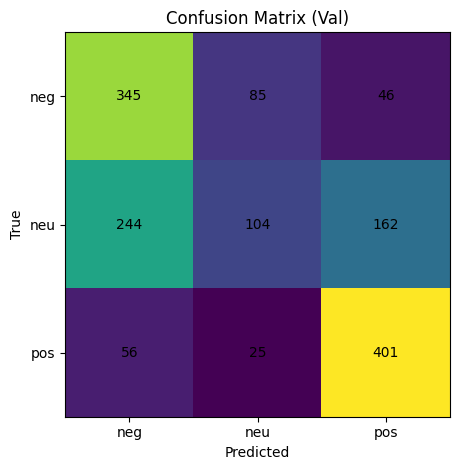

,precision,recall,f1-score,support
negative,0.534884,0.724790,0.615522,476.000000
neutral,0.485981,0.203922,0.287293,510.000000
positive,0.658456,0.831950,0.735105,482.000000
accuracy,0.579019,0.579019,0.579019,0.579019
macro avg,0.559774,0.586887,0.545973,1468.000000
weighted avg,0.558468,0.579019,0.540755,1468.000000


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

pred = trainer.predict(ds_val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Val)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1,2], ['neg','neu','pos'])
plt.yticks([0,1,2], ['neg','neu','pos'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, labels=[0,1,2],
                               target_names=['negative','neutral','positive'],
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report


# **Export of consolidated logs and model summaries**

**`Purpose`**

This block consolidates the experiment ledger into export files that support grading and documentation. It merges local runs with any team template, sorts them by macro-F1, and writes CSV and spreadsheet versions, along with summary tables for “best by model,” “runs per model,” and the “top ten by macro-F1.”

**`Input`**

The inputs are runs_log.csv produced by previous training cells and an optional Experiment_Log_Template.xlsx if a group sheet is in use. The code aligns column names and merges tables so that both personal and team entries appear together.

**`Output`**

The block writes exports/Experiment_Runs_All.csv and .xlsx, as well as Best_by_Model, Runs_per_Model, and Top10_by_F1 files in both CSV and Excel formats when possible. A short message confirms export success. These files are suitable for inclusion as appendix tables and as sources for figures.

**`Details`**

The merged table is sorted by macro-F1 to surface the strongest runs first. A “best by model” table keeps only the top row per backbone to support quick comparisons in the Results section. A “runs per model” count shows coverage across backbones. A “top ten by F1” slice provides a quick list of leading configurations for screenshots. The exports follow stable column names so that downstream formatting or conditional coloring in spreadsheets is straightforward.

**`Line-by-line Description`**

`from pathlib import Path` prepares folder handling, and `outdir = Path('exports'); outdir.mkdir(exist_ok=True)` ensures the output directory exists.

`df_runs = pd.read_csv('runs_log.csv') if os.path.exists('runs_log.csv') else pd.DataFrame()` loads the personal ledger or falls back to an empty table.

The branch that checks `Experiment_Log_Template.xlsx` merges a team sheet when available, aligns columns, and creates a unified table.

`if not df_all.empty:` guards the export steps so that the code only writes files when there is data to save.

`df_all = df_all.sort_values('f1_macro', ascending=False)` places the highest macro-F1 at the top.

`df_all.to_csv(...)` and `df_all.to_excel(...)` write consolidated logs for easy sharing.

The next group builds `best_by_model` by keeping the top row per backbone, writes it out, and creates a `rpm` count of runs per model.

In [ ]:
from pathlib import Path
outdir = Path('exports'); outdir.mkdir(exist_ok=True)

df_runs = pd.read_csv('runs_log.csv') if os.path.exists('runs_log.csv') else pd.DataFrame()
if os.path.exists('Experiment_Log_Template.xlsx'):
    df_team = pd.read_excel('Experiment_Log_Template.xlsx')
    for d in (df_runs, df_team):
        d.columns = [str(c).strip().lower() for c in d.columns]
    all_cols = sorted(set(df_runs.columns) | set(df_team.columns))
    df_runs = df_runs.reindex(columns=all_cols)
    df_team = df_team.reindex(columns=all_cols)
    df_all = pd.concat([df_team, df_runs], ignore_index=True).drop_duplicates()
else:
    df_all = df_runs

if not df_all.empty:
    if 'f1_macro' in df_all.columns:
        df_all = df_all.sort_values(by='f1_macro', ascending=False)
    df_all.to_csv(outdir/'Experiment_Runs_All.csv', index=False)
    try:
        df_all.to_excel(outdir/'Experiment_Runs_All.xlsx', index=False)
    except Exception as e:
        print("Excel export error:", e)

    if 'model' in df_all.columns and 'f1_macro' in df_all.columns:
        best_by_model = df_all.sort_values('f1_macro', ascending=False).drop_duplicates(subset=['model'])
        best_by_model.to_csv(outdir/'Best_by_Model.csv', index=False)
        best_by_model.to_excel(outdir/'Best_by_Model.xlsx', index=False)

        rpm = df_all['model'].value_counts().rename_axis('model').reset_index(name='runs')
        rpm.to_csv(outdir/'Runs_per_Model.csv', index=False)
        rpm.to_excel(outdir/'Runs_per_Model.xlsx', index=False)

    if 'f1_macro' in df_all.columns:
        top10 = df_all.head(10)
        top10.to_csv(outdir/'Top10_by_F1.csv', index=False)
        top10.to_excel(outdir/'Top10_by_F1.xlsx', index=False)
    print("Exported logs to exports/.")
else:
    print("No logs found yet.")


Exported logs to exports/.
